In [676]:
import os
import pandas as pd
import geopandas as gpd
import pylab as pl

import statsmodels.api as sm

import pysal as ps

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [677]:
if os.getenv("PUIDATA") is None:
    print ("must set PUIDATA env variable")
else:
    print('PUIDATA env variable is set')

PUIDATA env variable is set


# Data Munging

## Importing and cleaning energy usage data (LL84) per building in NYC for 2015 (reported in 2016)

In [614]:
energy = pd.read_csv("nyc_benchmarking_disclosure_data_reported_in_2016.csv")
print(len(energy))
energy.head(1)

13223


,﻿Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,...,Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,...,290.2,146.1,98052.0,98000.0,NaN,NaN,4/13/16 11:08 AM,NaN,NaN,NaN


In [615]:
energy.rename(columns={'NYC Borough, Block and Lot (BBL)':"BBL", \
                       'Reported NYC Building Identification Numbers (BINs)':'BIN', \
                       'Direct GHG Emissions (Metric Tons CO2e)':'directCO2e', \
                       'Indirect GHG Emissions (Metric Tons CO2e)':'indirectCO2e', \
                      'Total GHG Emissions (Metric Tons CO2e)':'Emissions(CO2e)', \
                      'Water Use (All Water Sources) (kgal)':'water_use', \
                       'Primary Property Type - Self Selected':'Property Type',
                      'Electricity Use - Grid Purchase (kBtu)':'grid_electricity(kBtu)'}, inplace=True)
energy.drop(['Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)', 'Property GFA - Self-reported (ft²)', \
            'DEP Provided Water Use (kgal)', 'Automatic Water Benchmarking Eligible', 'Co-reported BBL Status', \
            'BBLs Co-reported', 'Weather Normalized Site Natural Gas Use (therms)', 'Reported Water Method', \
            'District Chilled Water Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', \
            'District Hot Water Use (kBtu)', 'Diesel #2 Use (kBtu)', 'DOF Benchmarking Submission Status',
       'water_use', 'Release Date',
       'List of All Property Use Types at Property',
       'Largest Property Use Type', 'Metered Areas (Energy)', 'Metered Areas  (Water)',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type', 'Order', 'Weather Normalized Site Electricity (kWh)',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type', '﻿Record Number',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)','Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)', \
              'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Source EUI (kBtu/ft²)','Property Name', 'grid_electricity(kBtu)', 'Occupancy',
       'Parent Property Id', 'Parent Property Name','Site EUI (kBtu/ft²)','Number of Buildings - Self-reported'], axis=1, inplace=True)
energy.head(1)

,BBL,BIN,Street Number,Street Name,Zip Code,Borough,Property Type,Year Built,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Emissions(CO2e),directCO2e,indirectCO2e,DOF Property Floor Area (ft²)
0,1.003360e+09,1088884,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,Multifamily Housing,1982,87.0,74.4,115.7,Not Available,Not Available,436.3,290.2,146.1,98052.0


In [616]:
energy.columns

Index(['BBL', 'BIN', 'Street Number', 'Street Name', 'Zip Code', 'Borough',
       'Property Type', 'Year Built', 'ENERGY STAR Score',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Fuel Oil #4 Use (kBtu)',
       'Fuel Oil #5 & 6 Use (kBtu)', 'Emissions(CO2e)', 'directCO2e',
       'indirectCO2e', 'DOF Property Floor Area (ft²)'],
      dtype='object')

In [617]:
energy = energy[energy["BIN"].str.contains(';')==False]
energy = energy[energy["BIN"].str.contains(',')==False]
energy = energy[energy["BIN"].str.contains(':')==False]
energy = energy[energy["BIN"].str.contains('-')==False]
len(energy)

10745

In [618]:
energy['Zip Code'] = energy['Zip Code'].astype(str)
energy['Zip Code'] = energy['Zip Code'].map(lambda x: x.lstrip('').rstrip('.0'))
energy.sort(columns=['Emissions(CO2e)'], axis=0, ascending=False, inplace=True)

# another way I removed a single outlier before using STD method below
#energy = energy[energy["BIN"] != '1040808']
energy.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,BBL,BIN,Street Number,Street Name,Zip Code,Borough,Property Type,Year Built,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Emissions(CO2e),directCO2e,indirectCO2e,DOF Property Floor Area (ft²)
3293,1.013758e+09,1040808,660.0,MADISON AVENUE,10065,Manhattan,Office,1958,1.0,NaN,NaN,Not Available,Not Available,15014684.7,134.7,15014550.0,475963.0
903,1.007390e+09,1013043,103.0,8 AVENUE,10011,Manhattan,Office,1932,NaN,16887.0,20726.3,Not Available,Not Available,3221505.2,26.2,3221479.0,2161994.0
2936,1.012908e+09,1035762,2.0,EAST 55 STREET,10022,Manhattan,Hotel,1904,1.0,88338.3,106404.3,Not Available,Not Available,2482353.9,256.9,2482097.0,323504.0
3391,1.013910e+09,Not Available,981.0,MADISON AVENUE,10075,Manhattan,Hotel,1930,1.0,127429.9,153403.2,Not Available,Not Available,2470066.7,126.7,2469940.0,294142.0
1985,1.010110e+09,1023750,919.0,7 AVENUE,10019,Manhattan,Other - Lodging/Residential,1927,NaN,87342.8,105160.8,Not Available,Not Available,2320035.4,187.4,2319848.0,353996.0


In [619]:
print('Descriptive Statistics for Direct (on-site) Emissions (C02e):')
print("Standard Deviation: ", energy['directCO2e'].std())
print("Mean: ", energy['directCO2e'].mean())
print("Median: ", energy['directCO2e'].median())

Descriptive Statistics for Direct (on-site) Emissions (C02e):
Standard Deviation:  6673.66343245
Mean:  482.816907458
Median:  293.15


In [620]:
# removing outliers
energy = energy[energy['directCO2e'] 
                < (energy['directCO2e'].mean())
                + (energy['directCO2e'].std()*2)]
energy = energy[energy['directCO2e'] 
                > (energy['directCO2e'].mean())
                - (energy['directCO2e'].std()*2)]
energy = energy[energy['directCO2e'] != 0]
len(energy)

9497

In [621]:
# wow that's a big difference in STD; makes the above look wrong
print('Descriptive Statistics for Direct (on-site) Emissions (C02e):')
print("Standard Deviation: ", energy['directCO2e'].std())
print("Mean: ", energy['directCO2e'].mean())
print("Median: ", energy['directCO2e'].median())

Descriptive Statistics for Direct (on-site) Emissions (C02e):
Standard Deviation:  548.081045868
Mean:  432.594935243
Median:  311.8


## Importing and cleaning PLUTO data for Manhattan (other borough files were too large for Jupyter)

In [664]:
MHpluto = pd.read_csv('MN_reduced.csv').dropna()
MHpluto = MHpluto.sort_index(axis=1)
print(len(MHpluto))
MHpluto.columns

17478


Index(['Address', 'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea',
       'BldgClass', 'Block', 'BoroCode', 'Borough', 'BsmtCode', 'CB2010', 'CD',
       'CT2010', 'ComArea', 'Council', 'ExemptLand', 'ExemptTot', 'FactryArea',
       'FireComp', 'GarageArea', 'HealthArea', 'LandUse', 'Lot', 'LotArea',
       'LotType', 'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea',
       'OwnerType', 'PLUTOMapID', 'PolicePrct', 'ResArea', 'RetailArea',
       'SchoolDist', 'StrgeArea', 'Tract2010', 'UnitsRes', 'UnitsTotal',
       'Version', 'XCoord', 'YCoord', 'YearBuilt', 'ZipCode', 'ZoneDist1'],
      dtype='object')

In [665]:
MHpluto.drop(['Borough', 'Block', 'Lot', 'CD', 'Council', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', \
              'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs', 'ExemptLand', \
              'ExemptTot', 'YearBuilt', 'Version', 'ZoneDist1', 'UnitsRes', 'UnitsTotal', 'BsmtCode', \
              'AssessLand', 'BoroCode', 'FireComp', 'PolicePrct', 'SchoolDist', 'NumFloors', \
             'LotType', 'BldgClass', 'LandUse', 'OwnerType'], axis=1, inplace=True)
MHpluto.rename(columns={'ZipCode':'Zip Code'}, inplace=True)
MHpluto['Zip Code'] = MHpluto['Zip Code'].astype(str)
MHpluto['Zip Code'] = MHpluto['Zip Code'].map(lambda x: x.lstrip('').rstrip('.0'))

In [666]:
# creating GEOID10 from state + county + CT2010
# MHpluto['GEOID10'] = '36061' + 
MHpluto.head(3)

,Address,AssessTot,BBL,BldgArea,CB2010,CT2010,HealthArea,LotArea,PLUTOMapID,Tract2010,XCoord,YCoord,Zip Code
0,1 GOVERNORS ISLAND,156510900,1000010010,2725731,1018.0,5.0,8100.0,7736692,1,5,979071.0,190225.0,10004
1,1 LIBERTY ISLAND,12197250,1000010101,541886,1001.0,1.0,8200.0,541886,1,1,971677.0,190636.0,10004
5,MARGINAL STREET,32193900,1000020001,280000,1025.0,9.0,7700.0,209215,1,9,980670.0,194440.0,10004


In [383]:
energy.BBL = energy.BBL.astype(float)
MHpluto.BBL = MHpluto.BBL.astype(float)

In [ ]:
MHpluto.CT2010 = MHpluto.CT2010.astype(str)

In [ ]:
# need to combine columns to create full census GEOID

In [426]:
print(len(energy.BBL.unique()))
len(MHpluto.BBL.unique())

10744


17478

In [9]:
type(MHpluto.BBL[1])

numpy.float64

In [10]:
type(energy.BBL[1])

numpy.float64

## Merging building energy and PLUTO data for Manhattan (on Borough-Block-Lot).

In [622]:
energyPLUTO = pd.merge(energy, MHpluto, on=['BBL'], how='inner')
#energyPLUTO.rename(columns={'Tract2010':'CT2010'}, inplace=True)
#energyPLUTO['CT2010'] = energyPLUTO['CT2010'].astype(float)
print(len(energyPLUTO))
energyPLUTO.columns

1582


Index(['BBL', 'BIN', 'Street Number', 'Street Name', 'Zip Code', 'Borough',
       'Property Type', 'Year Built', 'ENERGY STAR Score',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Fuel Oil #4 Use (kBtu)',
       'Fuel Oil #5 & 6 Use (kBtu)', 'Emissions(CO2e)', 'directCO2e',
       'indirectCO2e', 'DOF Property Floor Area (ft²)', 'Address', 'AssessTot',
       'BldgArea', 'CB2010', 'CT2010', 'HealthArea', 'LotArea', 'PLUTOMapID',
       'Tract2010', 'XCoord', 'YCoord', 'ZipCode'],
      dtype='object')

In [624]:
energyPLUTO.tail(2)

,BBL,BIN,Street Number,Street Name,Zip Code,Borough,Property Type,Year Built,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),...,BldgArea,CB2010,CT2010,HealthArea,LotArea,PLUTOMapID,Tract2010,XCoord,YCoord,ZipCode
1580,1.005450e+09,1008806,752.0,BROADWAY,10003,Manhattan,Multifamily Housing,1981,NaN,NaN,...,147773,1005.0,57.0,5700.0,15030,1,57,986391.0,205326.0,10003.0
1581,1.014650e+09,1045808,1306.0,1 AVENUE,10021,Manhattan,Multifamily Housing,1979,NaN,NaN,...,357785,4000.0,124.0,4300.0,34286,1,124,996370.0,218622.0,10021.0


In [625]:
energyPLUTO.to_csv(path_or_buf='energyPLUTO.csv')

## Counting the buildings per zip code (not really necessary)

In [626]:
grouped = energyPLUTO.groupby('Zip Code')
zips = pd.DataFrame(grouped['Zip Code'].apply(np.size))
zips.rename(columns={'Zip Code':'Buildings/Zip'}, inplace=True)
zips.head(3)

,Buildings/Zip
Zip Code,
10001,75
10002,15
10003,68


## Importing and cleaning asthma data for Manhattan zip codes from 2012-2014. Discharge rate is per 10,000 population.

In [114]:
MHasthma = pd.read_csv('MHasthma.csv')
print(len(MHasthma))
print(MHasthma.columns)
MHasthma.head(3)

43
Index(['﻿Zip Code', 'Discharges2012-2014', 'Discharge_Rate'], dtype='object')


,﻿Zip Code,Discharges2012-2014,Discharge_Rate
0,10001,159,21.9
1,10002,592,23.9
2,10003,130,7.7


In [115]:
MHasthma.rename(columns={'﻿Zip Code':'Zip Code'}, inplace=True)

In [524]:
MHasthma['Zip Code'] = MHasthma['Zip Code'].astype(str)
MHasthma['Zip Code'] = MHasthma['Zip Code'].map(lambda x: x.lstrip('').rstrip('.0'))
type(MHasthma['Zip Code'][1])

str

In [525]:
MHasthma.head(2)

,Zip Code,Discharges2012-2014,Discharge_Rate
0,10001,159,21.9
1,10002,592,23.9


In [603]:
print('Descriptive Statistics for asthma rates in MN:')
print("Standard Deviation: ", MHasthma['Discharge_Rate'].std())
print("Mean: ", MHasthma['Discharge_Rate'].mean())
print("Median: ", MHasthma['Discharge_Rate'].median())

Descriptive Statistics for asthma rates in MN:
Standard Deviation:  18.5848847806
Mean:  19.0725
Median:  11.2


## Merging household income with building energy and PLUTO data (last two already merged)
### NOTE: stopped this to do it at zip code level instead

In [361]:
# census data from:
# http://data.beta.nyc/dataset/median-household-income-2010-census-tracts/resource/5a7c26b5-f8b0-4a3f-87fe-56a9c2ff5692
census = pd.read_csv('medianhouseholdincomecensustract.csv')
print(len(census))

5296


In [362]:
census.drop(['REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'PERC_RENT', 'PERC_OWN', 'OHU_RENT', \
            'OHU_OWN', 'State', 'COUNTY'], axis=1, inplace=True)
census.rename(columns={'TRACTCE10':'CT2010'}, inplace=True) 
census['CT2010'] = census['CT2010'].astype(float)

005 - Bronx
047 - Kings (Brooklyn)
061 - New York (Manhattan)
081 - Queens
085 - Richmond (Staten Island)

In [417]:
census['COUNTYFP10'] = census['COUNTYFP10'].astype(str)
MHcensus = census[census['COUNTYFP10'] == '61']
print('# of census tracts = ')
print(len(MHcensus))
MHcensus.head()

# of census tracts = 
288


,FID,STATEFP10,COUNTYFP10,CT2010,GEOID10,INTPTLAT10,INTPTLON10,HH_COUNT,MHI,MED_VAL,HOUSINGCOS,DISP_INC,energy_cos,Shape_Area
1699,1699,36,61,27100.0,36061027100,40.851939,-73.934291,2904,38125,536000,11068.7529,18670.89901,1764.860784,0.000021
1700,1700,36,61,12900.0,36061012900,40.765014,-73.999812,3354,76082,807900,21996.9303,29562.14132,1608.671016,0.000043
1701,1701,36,61,14401.0,36061014401,40.775249,-73.947552,2633,126518,668400,22181.4524,64418.82528,1718.090675,0.000008
1702,1702,36,61,9900.0,36061009900,40.752378,-74.008367,1091,122031,784700,26181.3474,58945.86916,1849.560190,0.000110
1703,1703,36,61,14601.0,36061014601,40.777192,-73.952161,2600,89846,713200,21611.7774,39691.01194,1415.971016,0.000008


### Filtering energy+PLUTO data by multifamily housing and grouping by census tract

In [472]:
energyPLUTO_res = energyPLUTO[energyPLUTO['Property Type'] == 'Multifamily Housing']
energyPLUTO_ct = energyPLUTO_res.groupby(['CT2010'])[['Weather Normalized Site EUI (kBtu/ft²)', 'Emissions(CO2e)'\
                                          , 'DOF Property Floor Area (ft²)']].sum()
energyPLUTO_ct['Total Site EUI'] = energyPLUTO_ct['Weather Normalized Site EUI (kBtu/ft²)'] * \
    energyPLUTO_ct['DOF Property Floor Area (ft²)']
energyPLUTO_ct.head(2)

,Weather Normalized Site EUI (kBtu/ft²),Emissions(CO2e),DOF Property Floor Area (ft²),Total Site EUI
CT2010,,,,
2.01,NaN,2219.2,NaN,NaN
2.02,321.1,2419.4,575321.0,184735573.1


In [473]:
energyPLUTO_ct['CT2010'] = energyPLUTO_ct.index.astype(object)
#energyPLUTO_ct['CT2010'] = energyPLUTO_ct['CT2010'].str.replace('.','')
#energyPLUTO_ct['CT2010'] = energyPLUTO_ct['CT2010'].str.strip('.')
#energyPLUTO_ct['CT2010'] = energyPLUTO_ct['CT2010'].astype(float)
y = len(energyPLUTO_ct)
energyPLUTO_ct.index = np.arange(0,y)

In [474]:
print(y)
energyPLUTO_ct.tail()

241


,Weather Normalized Site EUI (kBtu/ft²),Emissions(CO2e),DOF Property Floor Area (ft²),Total Site EUI,CT2010
236,361.2,3918.5,510199.0,1.842839e+08,295
237,162.9,1304.1,204287.0,3.327835e+07,303
238,263.7,1522.4,189994.0,5.010142e+07,309
239,148.1,3817.7,698425.0,1.034367e+08,317.03
240,1081.5,17620.9,3444757.0,3.725505e+09,317.04


In [422]:
incmnrgplt = pd.merge(energyPLUTO, census, on='CT2010', how='inner')
print('# of census tracts left = ')
print(len(incmnrgplt))
incmnrgplt.columns

# of census tracts left = 
257


Index(['BBL', 'BIN', 'Street Number', 'Street Name', 'Zip Code', 'Borough',
       'Property Type', 'Year Built', 'ENERGY STAR Score',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Fuel Oil #4 Use (kBtu)',
       'Fuel Oil #5 & 6 Use (kBtu)', 'Emissions(CO2e)',
       'DOF Property Floor Area (ft²)', 'CT2010', 'CB2010', 'ZipCode',
       'HealthArea', 'Address', 'LotArea', 'BldgArea', 'AssessTot',
       'Tract2010', 'XCoord', 'YCoord', 'PLUTOMapID', 'FID', 'STATEFP10',
       'COUNTYFP10', 'GEOID10', 'INTPTLAT10', 'INTPTLON10', 'HH_COUNT', 'MHI',
       'MED_VAL', 'HOUSINGCOS', 'DISP_INC', 'energy_cos', 'Shape_Area'],
      dtype='object')

## Importing income per capita per zip code in NYC
### NOTE: moving forward with this dataframe "income" instead of "census" above

In [605]:
income = pd.read_csv('income per capita by zip code.csv')
income.rename(columns={'HD01_VD01':'Income_Per_Capita', 'GEO.id2':'Zip Code'}, inplace=True)
income = income[income['Zip Code'] != 'Id2']
income = income[income['Income_Per_Capita'] != '-']
income.head()

,GEO.id,Zip Code,GEO.display-label,Income_Per_Capita,HD02_VD01
1,8600000US06390,6390,ZCTA5 06390,67122,21337
2,8600000US10001,10001,ZCTA5 10001,80990,15416
3,8600000US10002,10002,ZCTA5 10002,27867,1246
4,8600000US10003,10003,ZCTA5 10003,80936,5333
5,8600000US10004,10004,ZCTA5 10004,90205,13349


In [610]:
income['Income_Per_Capita'] = income['Income_Per_Capita'].astype(float)

In [611]:
print('Descriptive statistics for income per capita in NYC zip codes:')
print("Standard Deviation: ", income['Income_Per_Capita'].std())
print("Mean: ", income['Income_Per_Capita'].mean())
print("Median: ", income['Income_Per_Capita'].median())

Descriptive statistics for income per capita in NYC zip codes:
Standard Deviation:  16449.5007106
Mean:  32054.127867
Median:  27951.5


# 2.1 What is the relationship between building energy use and public health, measured by the local asthma hospitalization rate?

### Merging just the building energy data with asthma data. Grouping building energy by zip code first. Leaving out PLUTO and Census for now.

### Using Weather Normalized Site EUI, because the environmental impacts of a building's electricity source don't affect the health of people around the building (as long as, like most buildings, it gets its electricity from the grid).

In [627]:
energy_Zip = energy.groupby(['Zip Code'])[['Weather Normalized Site EUI (kBtu/ft²)', 'Emissions(CO2e)',\
                'directCO2e', 'DOF Property Floor Area (ft²)']].sum()

In [628]:
energy_Zip['Aggregated Site Energy Use'] = energy_Zip['Weather Normalized Site EUI (kBtu/ft²)'] * \
    energy_Zip['DOF Property Floor Area (ft²)']
energy_Zip['Agg_Direct_Emissions'] = energy_Zip['directCO2e'] * \
    energy_Zip['DOF Property Floor Area (ft²)']
energy_Zip['Zip Code'] = energy_Zip.index
x = len(energy_Zip)
energy_Zip.index = np.arange(0,x)
print(x)
energy_Zip.head()

187


,Weather Normalized Site EUI (kBtu/ft²),Emissions(CO2e),directCO2e,DOF Property Floor Area (ft²),Aggregated Site Energy Use,Agg_Direct_Emissions,Zip Code
0,11912.7,245280.3,97241.3,41583640.0,4.953734e+11,4.043647e+12,10001
1,2443.0,21181.2,11223.7,3387591.0,8.275885e+09,3.802131e+10,10002
2,110917.3,2587807.6,75999.6,26338763.0,2.921424e+12,2.001735e+12,10003
3,1742.7,64236.7,9127.2,9053649.0,1.577779e+10,8.263447e+10,10004
4,24169.6,974108.1,9344.8,13079595.0,3.161286e+11,1.222262e+11,10005


In [650]:
MHasthmaZip = pd.merge(energy_Zip, MHasthma, on=['Zip Code'], how='inner')
MHasthmaZip['Discharges2012-2014'] = MHasthmaZip['Discharges2012-2014'].str.replace(',', '')
MHasthmaZip['Discharges2012-2014'] = MHasthmaZip['Discharges2012-2014'].astype(float)
MHasthmaZip['Zip Code'] = MHasthmaZip['Zip Code'].astype(int)
MHasthmaZip.to_csv(path_or_buf='MN_asthma_energy_per_zip.csv')
print(len(MHasthmaZip))
MHasthmaZip.head()

42


,Weather Normalized Site EUI (kBtu/ft²),Emissions(CO2e),directCO2e,DOF Property Floor Area (ft²),Aggregated Site Energy Use,Agg_Direct_Emissions,Zip Code,Discharges2012-2014,Discharge_Rate
0,11912.7,245280.3,97241.3,41583640.0,4.953734e+11,4.043647e+12,10001,159.0,21.9
1,2443.0,21181.2,11223.7,3387591.0,8.275885e+09,3.802131e+10,10002,592.0,23.9
2,110917.3,2587807.6,75999.6,26338763.0,2.921424e+12,2.001735e+12,10003,130.0,7.7
3,1742.7,64236.7,9127.2,9053649.0,1.577779e+10,8.263447e+10,10004,NaN,NaN
4,24169.6,974108.1,9344.8,13079595.0,3.161286e+11,1.222262e+11,10005,6.0,2.2


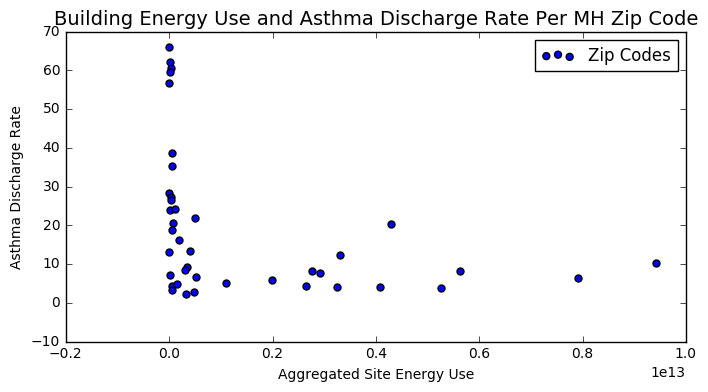

In [642]:
pl.figure(figsize=(8,4))
pl.scatter(MHasthmaZip['Aggregated Site Energy Use'], MHasthmaZip['Discharge_Rate'], s=100, label=('Zip Codes'), marker=".")
pl.xlabel("Aggregated Site Energy Use", fontsize=10)
pl.ylabel("Asthma Discharge Rate", fontsize=10)
pl.title("Building Energy Use and Asthma Discharge Rate Per MH Zip Code", fontsize=14)
pl.legend()

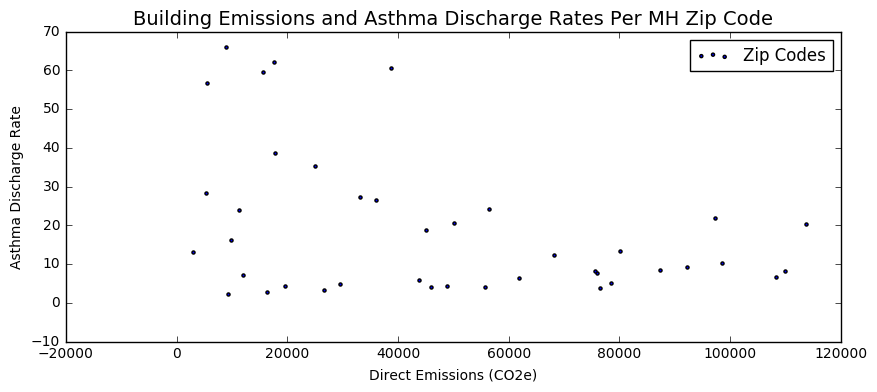

In [644]:
pl.figure(figsize=(10,4))
pl.scatter(MHasthmaZip['directCO2e'], MHasthmaZip['Discharge_Rate'], label=('Zip Codes'), marker=".")
pl.xlabel("Direct Emissions (CO2e)", fontsize=10)
pl.ylabel("Asthma Discharge Rate", fontsize=10)
pl.title("Building Emissions and Asthma Discharge Rates Per MH Zip Code", fontsize=14)
pl.legend()

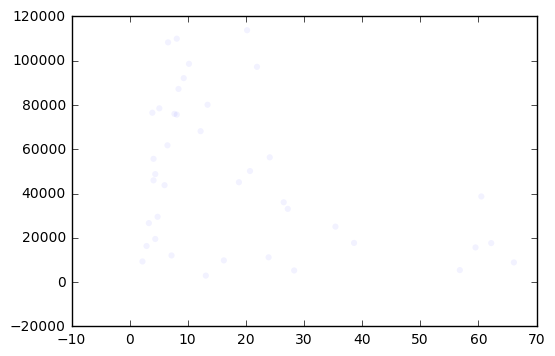

In [652]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(MHasthmaZip['Discharge_Rate'], MHasthmaZip['directCO2e'], c='blue', alpha=0.05, edgecolors='none')
#ax.set_yscale('log')
#ax.set_xscale('log')

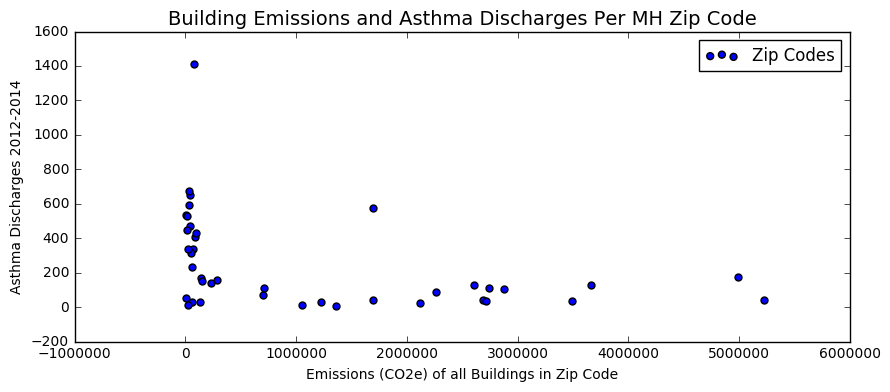

In [598]:
pl.figure(figsize=(10,4))
pl.scatter(MHasthmaZip['Emissions(CO2e)'], MHasthmaZip['Discharges2012-2014'], s=100, \
           cmap='bone', label=('Zip Codes'), marker=".")
pl.xlabel("Emissions (CO2e) of all Buildings in Zip Code", fontsize=10)
pl.ylabel("Asthma Discharges 2012-2014", fontsize=10)
pl.title("Building Emissions and Asthma Discharges Per MH Zip Code", fontsize=14)
pl.legend()

In [653]:
MHpluto.columns

Index(['Address', 'AssessTot', 'BBL', 'BldgArea', 'CB2010', 'CT2010',
       'HealthArea', 'LotArea', 'PLUTOMapID', 'Tract2010', 'XCoord', 'YCoord',
       'ZipCode'],
      dtype='object')

In [655]:
MHasthmaZip.columns

Index(['Weather Normalized Site EUI (kBtu/ft²)', 'Emissions(CO2e)',
       'directCO2e', 'DOF Property Floor Area (ft²)',
       'Aggregated Site Energy Use', 'Agg_Direct_Emissions', 'Zip Code',
       'Discharges2012-2014', 'Discharge_Rate'],
      dtype='object')

In [ ]:
zipshape = gpd.read_file(os.getenv('PUIDATA')+ "/ZIP_CODE_040114.shp")

In [684]:
type(MHasthmaZip['Zip Code'][1])

numpy.int64

In [685]:
zipshape.rename(columns={'ZIPCODE': 'Zip Code'}, inplace=True)
zipshape['Zip Code'] = zipshape['Zip Code'].astype(int)
zipshape.head(2)

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,Zip Code,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."


In [689]:
# merging with mapPLUTO data for mapping
MNasthmazip_shape = pd.merge(MHasthmaZip, zipshape, on='Zip Code', how='inner')
MNasthmazip_shape.to_csv(path_or_buf='MN_asthma_energy_zip_shp.csv')
MNasthmazip_shape.head(2)

,Weather Normalized Site EUI (kBtu/ft²),Emissions(CO2e),directCO2e,DOF Property Floor Area (ft²),Aggregated Site Energy Use,Agg_Direct_Emissions,Zip Code,Discharges2012-2014,Discharge_Rate,AREA,...,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,geometry
0,11912.7,245280.3,97241.3,41583640.0,4.953734e+11,4.043647e+12,10001,159.0,21.9,1.779494e+07,...,New York,061,22413.0,New York,0.0,0.0,NY,36,http://www.usps.com/,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,2443.0,21181.2,11223.7,3387591.0,8.275885e+09,3.802131e+10,10002,592.0,23.9,2.628013e+07,...,New York,061,81305.0,New York,0.0,0.0,NY,36,http://www.usps.com/,"POLYGON ((991339.8703228086 207576.7837151289,..."


TypeError: There is no Line2D property "column"

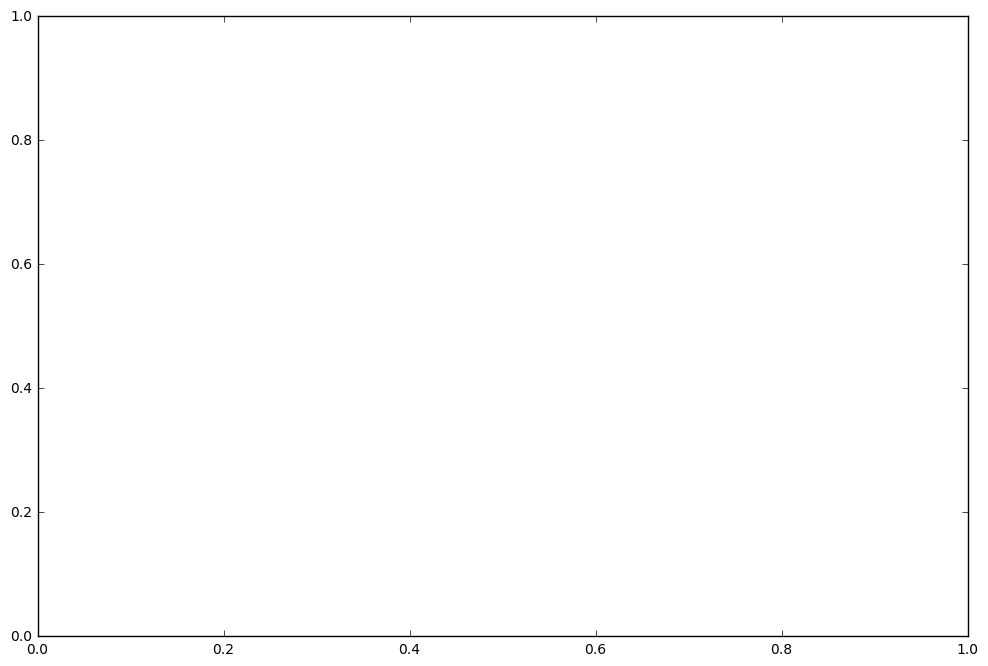

In [692]:
f, (ax1) = pl.subplots(figsize=(12,8))
MNasthmazip_shape.plot(column='Agg_Direct_Emissions',cmap='gnuplot_r',alpha=.9,linewidth=0.4,ax=ax1)
ax1.set_title("Choropleth of aggregated building emissions by Zipcode)", fontsize=20)
MNasthmazip_shape.plot(alpha=0.01, linewidth=0.25, ax=ax1)

vmin, vmax = min(MNasthmazip_shape['Agg_Direct_Emissions'].values), \
            max(MNasthmazip_shape['Agg_Direct_Emissions'].values)

fig = ax1.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = pl.cm.ScalarMappable(cmap='gnuplot', norm=pl.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

## 2.2 What is the relationship between neighborhood income and residential building energy use?

In [ ]:
incmnrgplt.columns

In [410]:
len(incmnrgplt)

257

In [409]:
incmnrgplt['Property Type'].unique()

array(['Office', 'Hotel', 'Multifamily Housing', 'Other',
       'Residence Hall/Dormitory', 'College/University', 'K-12 School'], dtype=object)

In [423]:
incmnrgplt = incmnrgplt[incmnrgplt['Property Type'] == 'Multifamily Housing']
print('Number of census tracts out of 257 that have multifamily housing  =')
len(incmnrgplt)

Number of census tracts out of 257 that have multifamily housing  =


74

In [406]:
incmnrgplt.to_csv(path_or_buf='incmnrgplt.csv')

### The above was affected by bad CT values in PLUTO data, so doing it with new income per zip code data. Merging that with energy data now

#### This is all NYC, not just Manhattan

In [581]:
energy_res = energy[energy['Property Type'] == 'Multifamily Housing']
energy_res_zip = energy_res.groupby(['Zip Code'])[['Weather Normalized Site EUI (kBtu/ft²)', 'Emissions(CO2e)',\
            'directCO2e', 'Weather Normalized Source EUI (kBtu/ft²)', 'DOF Property Floor Area (ft²)']].sum()

In [583]:
energy_res_zip['Aggregated Res Site Energy Use'] = energy_res_zip['Weather Normalized Site EUI (kBtu/ft²)'] * \
    energy_res_zip['DOF Property Floor Area (ft²)']
energy_res_zip['Aggregated Res Source Energy Use'] = energy_res_zip['Weather Normalized Source EUI (kBtu/ft²)'] * \
    energy_res_zip['DOF Property Floor Area (ft²)']
energy_res_zip['Agg_Direct_Emissions'] = energy_res_zip['directCO2e'] * \
    energy_res_zip['DOF Property Floor Area (ft²)']
energy_res_zip.drop(['directCO2e', 'Emissions(CO2e)'], axis=1, inplace=True)
energy_res_zip['Zip Code'] = energy_res_zip.index
x = len(energy_res_zip)
energy_res_zip.index = np.arange(0,x)
print(x)
energy_res_zip.head()

167


,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),DOF Property Floor Area (ft²),Aggregated Res Site Energy Use,Aggregated Res Source Energy Use,Agg_Direct_Emissions,Zip Code
0,3737.7,6675.8,12294952.0,4.595484e+10,8.207864e+10,4.183530e+11,10001
1,2035.6,3580.6,3483885.0,7.091796e+09,1.247440e+10,3.285896e+10,10002
2,40662.6,52957.8,16243362.0,6.604973e+11,8.602127e+11,8.287981e+11,10003
3,656.9,1236.0,1827681.0,1.200604e+09,2.259014e+09,5.865942e+09,10004
4,23710.8,29409.8,6442096.0,1.527472e+11,1.894608e+11,5.016976e+10,10005


In [584]:
income_energy = pd.merge(income, energy_res_zip, on=['Zip Code'], how='inner')
income_energy = income_energy[income_energy['Income_Per_Capita'].str.contains('-')==False]
print(len(income_energy))
income_energy.head()

152


,GEO.id,Zip Code,GEO.display-label,Income_Per_Capita,HD02_VD01,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),DOF Property Floor Area (ft²),Aggregated Res Site Energy Use,Aggregated Res Source Energy Use,Agg_Direct_Emissions
0,8600000US10001,10001,ZCTA5 10001,80990,15416,3737.7,6675.8,12294952.0,4.595484e+10,8.207864e+10,4.183530e+11
1,8600000US10002,10002,ZCTA5 10002,27867,1246,2035.6,3580.6,3483885.0,7.091796e+09,1.247440e+10,3.285896e+10
2,8600000US10003,10003,ZCTA5 10003,80936,5333,40662.6,52957.8,16243362.0,6.604973e+11,8.602127e+11,8.287981e+11
3,8600000US10004,10004,ZCTA5 10004,90205,13349,656.9,1236.0,1827681.0,1.200604e+09,2.259014e+09,5.865942e+09
4,8600000US10005,10005,ZCTA5 10005,96940,13388,23710.8,29409.8,6442096.0,1.527472e+11,1.894608e+11,5.016976e+10


In [587]:
income_energy['Income_Per_Capita'] = income_energy['Income_Per_Capita'].astype(float)

In [589]:
income_energy.to_csv(path_or_buf='income_energy.csv')

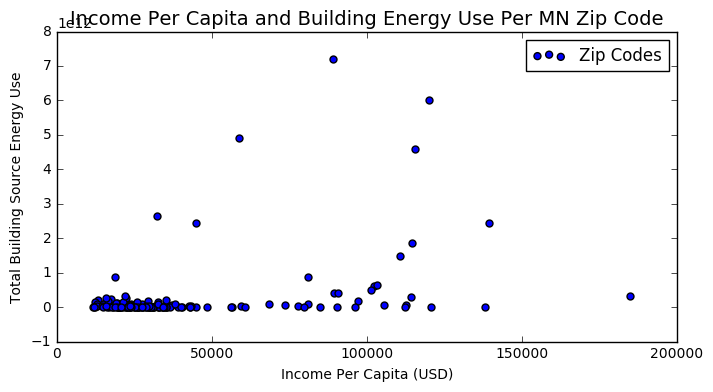

In [593]:
pl.figure(figsize=(8,4))
pl.scatter(income_energy['Income_Per_Capita'], income_energy['Aggregated Res Source Energy Use'], s=100, \
           cmap='bone', label=('Zip Codes'), marker=".")
pl.xlabel("Income Per Capita (USD)", fontsize=10)
pl.ylabel("Total Building Source Energy Use", fontsize=10)
pl.title("Income Per Capita and Building Energy Use Per MN Zip Code", fontsize=14)
pl.legend()